## Define Function and its Symmetry

In [1]:
import random
import torch
import matplotlib.pyplot as plt
RANDOM_SEED = 41

from constants import DTYPE, LABEL_FONT_SIZE, DPI, FIG_HEIGHT

random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

N_RUNS = 10
_random_seeds = [random.randint(0, 10000) for _ in range(N_RUNS)]

## Generate Dataset

In [2]:
N_SAMPLES = 100_000
n_features = 2
LAMBDA = 1
RHO = 1

SYMMETRY_DIM = 1

cost_matrix = torch.tensor([[LAMBDA, 0], [0, RHO]], dtype=DTYPE)

def f(state, cost_matrix=cost_matrix):
    """Evaluates f:M \rightarrow N for a batch of states s and a cost_matrix.
    Args:
        state: torch.Tensor of shape (batch_size, n_features)
    Returns:
        torch.Tensor of shape (batch_size,)
    """
    return torch.einsum('bi,ij,jb->b', state, cost_matrix, state.T)

p = torch.randn(N_SAMPLES, n_features, dtype=DTYPE)
n = f(p)

## Symmetry Discovery

### Step 1: Learn Basis of Kernel at each Point

In [3]:
KERNEL_DIM=1
EPSILON_BALL = 0.05
EPSILON_LEVEL_SET = 0.005

from src.learning.symmetry_discovery.differential.kernel_pprox import pointwise_kernel_approx

kernel_bases = pointwise_kernel_approx(p=p, n=n, kernel_dim=KERNEL_DIM, epsilon_ball=EPSILON_BALL, epsilon_level_set=EPSILON_LEVEL_SET)

/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/differential/kernel_pprox.py:62: UserWarning: Kernel Approximation currently only supports real-valued functions.
  warnings.warn("Kernel Approximation currently only supports real-valued functions.")
Compute Kernel Samples...: 100000it [00:02, 49397.35it/s]
Compute Point-Wise Bases...: 100%|██████████| 100000/100000 [00:05<00:00, 18999.28it/s]
INFO:root:Computed kernel bases from:
  - multiple tangent vectors for 66.66% of samples (good)
  - one tangent vector for 13.72% of samples (okay)
  - no tangent vector for 19.62% of samples (not good, no basis).


## Compare Both Approaches

In [4]:
diff_func_generators = []
N_STEPS = 30_000
BATCH_SIZE=128

In [5]:
from src.experiments.diff_vs_func.compare_generators import DiffFuncGenerator
g_oracle = torch.tensor([[0, -1], [1, 0]], dtype=DTYPE).unsqueeze(0)

for idx_run in range(N_RUNS):
    print(f"Run {idx_run+1} out of {N_RUNS}")

    g_init_all = torch.rand((1,n_features,n_features), dtype=DTYPE)
    g_0 = torch.nn.Parameter(g_init_all)

    diff_func_generator = DiffFuncGenerator(
        g_0=g_0,
        p=p,
        bases=kernel_bases,
        func=f,
        batch_size=BATCH_SIZE,
        n_steps = N_STEPS,
        g_oracle=g_oracle,
        random_seed=_random_seeds[idx_run]
    )
    diff_func_generator.optimize()
    diff_func_generators.append(diff_func_generator)

Run 1 out of 10


/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/differential/diff_generator.py:53: UserWarning: Differential Generator is not Normalized During Training
  warnings.warn("Differential Generator is not Normalized During Training")
/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/functional/func_generator.py:50: UserWarning: Sampled group actions are in 2pi range.
  warnings.warn("Sampled group actions are in 2pi range.")
/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/experiments/diff_vs_func/compare_generators.py:35: UserWarning: Current evaluation only supports rotation symmetry.
  warnings.warn("Current evaluation only supports rotation symmetry.")
Learning Differential and Functional Generator: 100%|██████████| 30000/30000 [04:08<00:00, 120.90it/s, Generator Span Diff. Loss=0.66, Generator Span Func. Loss=0.55]   


Run 2 out of 10


Learning Differential and Functional Generator: 100%|██████████| 30000/30000 [04:12<00:00, 118.93it/s, Generator Span Diff. Loss=0.61, Generator Span Func. Loss=0.02]  


Run 3 out of 10


Learning Differential and Functional Generator: 100%|██████████| 30000/30000 [04:11<00:00, 119.45it/s, Generator Span Diff. Loss=2.04, Generator Span Func. Loss=0.30]   


Run 4 out of 10


Learning Differential and Functional Generator: 100%|██████████| 30000/30000 [04:12<00:00, 118.88it/s, Generator Span Diff. Loss=1.36, Generator Span Func. Loss=0.05]  


Run 5 out of 10


Learning Differential and Functional Generator: 100%|██████████| 30000/30000 [04:13<00:00, 118.49it/s, Generator Span Diff. Loss=1.96, Generator Span Func. Loss=27.86]  


Run 6 out of 10


Learning Differential and Functional Generator: 100%|██████████| 30000/30000 [04:11<00:00, 119.42it/s, Generator Span Diff. Loss=2.64, Generator Span Func. Loss=0.08]   


Run 7 out of 10


Learning Differential and Functional Generator: 100%|██████████| 30000/30000 [04:13<00:00, 118.30it/s, Generator Span Diff. Loss=0.76, Generator Span Func. Loss=0.04]   


Run 8 out of 10


Learning Differential and Functional Generator: 100%|██████████| 30000/30000 [04:09<00:00, 120.08it/s, Generator Span Diff. Loss=1.23, Generator Span Func. Loss=0.03]  


Run 9 out of 10


Learning Differential and Functional Generator: 100%|██████████| 30000/30000 [04:14<00:00, 117.73it/s, Generator Span Diff. Loss=1.19, Generator Span Func. Loss=0.48]   


Run 10 out of 10


Learning Differential and Functional Generator: 100%|██████████| 30000/30000 [04:10<00:00, 119.85it/s, Generator Span Diff. Loss=1.46, Generator Span Func. Loss=0.07]   


## Visualize Learned Generators
- Top row: differential
- Bottom row: functional

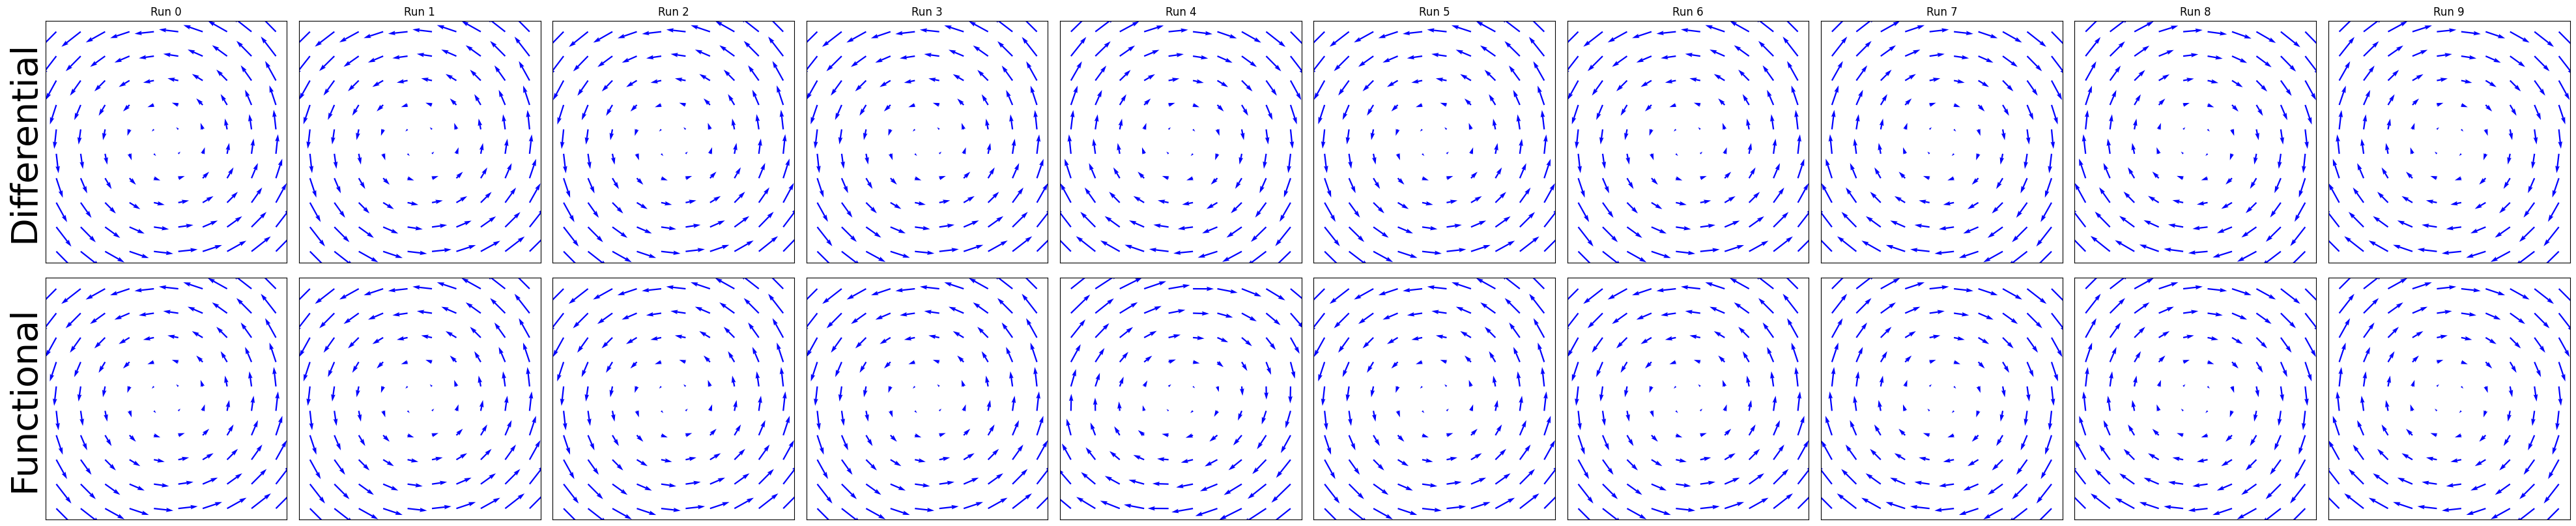

In [41]:
from src.plotting.differential.vector_field import plot_learned_generator
import matplotlib.pyplot as plt
FIG_UNIT=5
fig, axes = plt.subplots(2, N_RUNS, figsize=(FIG_UNIT * N_RUNS, FIG_UNIT * 2), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.05, hspace=0.05)
for i, ax in enumerate(axes[0]):
    plot_learned_generator(diff_func_generators[i].g_diff_norm, ax, title=f"Run {i}", quiver_scale=4)
for i, ax in enumerate(axes[1]):
    plot_learned_generator(diff_func_generators[i].g_func_norm, ax, quiver_scale=4)
axes[0,0].set_ylabel("Differential", fontsize=LABEL_FONT_SIZE*2)
axes[1,0].set_ylabel("Functional", fontsize=LABEL_FONT_SIZE*2)
axes[0,0].set_xticks([])
axes[1,0].set_yticks([])

plt.show()

## Plot loss functions

In [8]:
import numpy as np

# Function Space Losses
diff_losses_func_space_all_runs = np.array([np.array(result.diff_losses_func_space) for result in diff_func_generators])
func_losses_func_space_all_runs = np.array([np.array(result.func_losses_func_space) for result in diff_func_generators])
oracle_losses_func_space_all_runs = np.array([np.array(result.oracle_losses_func_space) for result in diff_func_generators])

In [9]:
# Generator Span Loss

diff_losses_generator_span_all_runs = np.array([np.array(result.diff_losses) for result in diff_func_generators])
func_losses_generator_span_all_runs = np.array([np.array(result.func_losses) for result in diff_func_generators])
oracle_losses_generator_span_all_runs = np.array([np.array(result.oracle_losses) for result in diff_func_generators])

In [10]:
# Symmetry Span Loss
diff_losses_generator_span_sym_all_runs = np.array([np.array(result.diff_losses_symmetry) for result in diff_func_generators])
func_losses_generator_span_sym_all_runs = np.array([np.array(result.func_losses_symmetry) for result in diff_func_generators])
oracle_losses_generator_span_sym_all_runs = np.array([np.array(result.oracle_losses_symmetry) for result in diff_func_generators])

# Max Span Loss
diff_losses_generator_span_max_all_runs = np.array([np.array(result.diff_losses_maximal) for result in diff_func_generators])
func_losses_generator_span_max_all_runs = np.array([np.array(result.func_losses_maximal) for result in diff_func_generators])
oracle_losses_generator_span_max_all_runs = np.array([np.array(result.oracle_losses_maximal) for result in diff_func_generators])

## Plot func vs. generator loss

In [11]:
from src.plotting.loss_over_time import compute_mean_and_std_losses
import matplotlib.gridspec as gridspec

import numpy as np
from scipy.ndimage import uniform_filter1d

def compute_mean_and_std_losses(losses: np.array, window_size: int):
    """Smoothes an array and computes mean and variance of an array in log-scale."""
    
    smoothed_losses = uniform_filter1d(losses, size=window_size, axis=1, mode='reflect')
    mean_losses_smoothed = smoothed_losses.mean(axis=0)
    log_std_losses_smoothed = np.exp(np.std(np.log(smoothed_losses + 1e-8), axis=0))
    return mean_losses_smoothed, log_std_losses_smoothed

WINDOW_SIZE = 25
COLOR_DIFF = "green"
COLOR_FUNC = "blue"
COLOR_ORACLE= "red"

losses_func_space = (diff_losses_func_space_all_runs, func_losses_func_space_all_runs, oracle_losses_func_space_all_runs)
losses_generator_span = (diff_losses_generator_span_all_runs, func_losses_generator_span_all_runs, oracle_losses_generator_span_all_runs)

losses_sym = (diff_losses_generator_span_sym_all_runs, func_losses_generator_span_sym_all_runs, [])
losses_max = (diff_losses_generator_span_max_all_runs, func_losses_generator_span_max_all_runs, [])

In [16]:
import matplotlib.ticker as ticker

def plot_combined_grid(
    losses_set_1_func1, losses_set_2_func1,
    losses_set_1_func2, losses_set_2_func2,
    labels: list,
    y_labels_func1: list,
    y_labels_func2: list,
    savepath: str = None
):
    all_losses_func1 = [losses_set_1_func1, losses_set_2_func1]
    all_losses_func2 = [losses_set_1_func2, losses_set_2_func2]

    fig = plt.figure(figsize=(FIG_HEIGHT*3, FIG_HEIGHT))
    gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1])

    # BIG plots spanning two rows
    ax1 = fig.add_subplot(gs[:, 0])  # ax1 spans both rows in column 0
    ax2 = fig.add_subplot(gs[:, 1])  # ax2 spans both rows in column 1

    # Stacked small plots in third column
    ax3 = fig.add_subplot(gs[0, 2])
    ax4 = fig.add_subplot(gs[1, 2], sharex=ax3)

    axes_func1 = [ax1, ax2]
    axes_func2 = [ax3, ax4]

    # Change x-axes ticks to 10^3 scale
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((3, 3))
    ax1.xaxis.set_major_formatter(formatter)
    ax2.xaxis.set_major_formatter(formatter)
    ax4.xaxis.set_major_formatter(formatter)
    ax1.xaxis.get_offset_text().set_fontsize(LABEL_FONT_SIZE)
    ax2.xaxis.get_offset_text().set_fontsize(LABEL_FONT_SIZE)
    ax4.xaxis.get_offset_text().set_fontsize(LABEL_FONT_SIZE)


    for idx, (losses, ax) in enumerate(zip(all_losses_func1, axes_func1)):
        diff_losses, func_losses, oracle_losses = losses

        plot_oracle = len(oracle_losses) > 0
        diff_mean, diff_var = compute_mean_and_std_losses(diff_losses, window_size=WINDOW_SIZE)
        func_mean, func_var = compute_mean_and_std_losses(func_losses, window_size=WINDOW_SIZE)
        if plot_oracle:
            oracle_mean, oracle_var = compute_mean_and_std_losses(oracle_losses, window_size=WINDOW_SIZE)

        ax.plot(diff_mean, label=labels[0], color=COLOR_DIFF)
        ax.plot(func_mean, label=labels[1], color=COLOR_FUNC)

        ax.fill_between(range(len(diff_mean)), diff_mean / diff_var, diff_mean * diff_var, alpha=0.2, color=COLOR_DIFF)
        ax.fill_between(range(len(func_mean)), func_mean / func_var, func_mean * func_var, alpha=0.2, color=COLOR_FUNC)

        if plot_oracle:
            ax.plot(oracle_mean, label=labels[2], color=COLOR_ORACLE)
            ax.fill_between(range(len(oracle_mean)), oracle_mean / oracle_var, oracle_mean * oracle_var, alpha=0.2, color=COLOR_ORACLE)

        ax.set_ylabel(y_labels_func1[idx], fontsize=LABEL_FONT_SIZE*2)
        ax.set_yscale("log")
        ax.tick_params(axis='both', which='major', labelsize=LABEL_FONT_SIZE)
        ax.set_xlabel("Gradient Step", fontsize=LABEL_FONT_SIZE)
        ax.grid()

    for idx, (losses, ax) in enumerate(zip(all_losses_func2, axes_func2)):
        diff_losses, func_losses, oracle_losses = losses

        plot_oracle = len(oracle_losses) > 0
        diff_mean, diff_var = compute_mean_and_std_losses(diff_losses, window_size=WINDOW_SIZE)
        func_mean, func_var = compute_mean_and_std_losses(func_losses, window_size=WINDOW_SIZE)
        if plot_oracle:
            oracle_mean, oracle_var = compute_mean_and_std_losses(oracle_losses, window_size=WINDOW_SIZE)

        ax.plot(diff_mean, label=labels[0], color=COLOR_DIFF)
        ax.plot(func_mean, label=labels[1], color=COLOR_FUNC)

        ax.fill_between(range(len(diff_mean)), diff_mean / diff_var, diff_mean * diff_var, alpha=0.2, color=COLOR_DIFF)
        ax.fill_between(range(len(func_mean)), func_mean / func_var, func_mean * func_var, alpha=0.2, color=COLOR_FUNC)

        if plot_oracle:
            ax.plot(oracle_mean, label=labels[2], color=COLOR_ORACLE)
            ax.fill_between(range(len(oracle_mean)), oracle_mean / oracle_var, oracle_mean * oracle_var, alpha=0.2, color=COLOR_ORACLE)

        ax.set_ylabel(y_labels_func2[idx], fontsize=LABEL_FONT_SIZE*2)
        ax.set_yscale("log")
        ax.tick_params(axis='both', which='major', labelsize=LABEL_FONT_SIZE)
        ax.grid()
    ax.set_xlabel("Gradient Step", fontsize=LABEL_FONT_SIZE)
    ax3.tick_params(labelbottom=False)


    fig.text(
        0.85,
        0.555,
        "$\oplus$",
        fontsize=100,
        ha='center',
        va='center'
    )
    fig.text(
        0.6675,
        0.55,
        "$=$",
        fontsize=100,
        ha='center',
        va='center'
    )

    # Unified legend
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, ncols=3, loc='lower center', bbox_to_anchor=(0.5, -0.1), fontsize=LABEL_FONT_SIZE*2)



    fig.tight_layout(rect=[0, 0.05, 1, 1])  # leave space for legend

    if savepath:
        fig.savefig(savepath, bbox_inches='tight', pad_inches=0.05, dpi=DPI)

    plt.close(fig)


In [17]:
plot_combined_grid(losses_func_space,losses_generator_span, losses_sym, losses_max,
                      labels=["Differential", "Functional", "Oracle"],
                    y_labels_func2=["$d^{sym}$", "$d^{max}$", None],
                      y_labels_func1=["$d^{func}$", "$d^{span}$"],
                      savepath="losses_diff_vs_func"
)